In [33]:
import matplotlib.pyplot as mp

import cartopy
import numpy
import xarray
import pandas
import netCDF4
import scipy.stats
import cmocean

mp.rcParams.update({'mathtext.default': 'regular'})

In [2]:
!ls /beegfs/DATA/pritchard/blangenb/CRU_DATA/

cru_ts4.01.1901.2016.pre.dat.nc  cru_ts4.01.1901.2016.tmp.dat.nc
cru_ts4.01.1901.2016.tmn.dat.nc  cru_ts4.01.1901.2016.tmx.dat.nc


In [3]:
tmp_filename = '/beegfs/DATA/pritchard/blangenb/CRU_DATA/cru_ts4.01.1901.2016.tmp.dat.nc'

ds_tmp = xarray.open_dataset(tmp_filename, decode_times=False)

tmp_time_var = ds_tmp['time']
tmp_datetime = netCDF4.num2date(tmp_time_var.values, \
                                tmp_time_var.units, \
                                calendar='standard')

tmp_time = tmp_time_var.values
tmp_data = ds_tmp['tmp'].values
tmp_lon = ds_tmp['lon'].values
tmp_lat = ds_tmp['lat'].values

In [4]:
tmp_time_mean = numpy.nanmean(tmp_data, axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


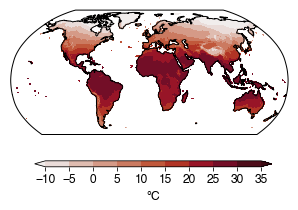

In [5]:
fontsize = 12

map_proj = cartopy.crs.Robinson()
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(4.25,2.5))

ax = fig.add_subplot(111, projection=map_proj)

levels = numpy.arange(-10,35.1,5)
contour_plot = ax.contourf(tmp_lon, tmp_lat, \
                           tmp_time_mean, \
                           levels=levels, \
                           cmap = cmocean.cm.amp, \
                           transform=data_proj, \
                           extend='both')

ax.coastlines()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0,axpos.y0-0.15,axpos.width,0.0333])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')

cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\degree$C', fontsize=fontsize)

fig.tight_layout()

calculate trends during 2000 to present day

1. get subsets of time for years you want the trend over

2. use ```scipy.stats.linregress``` to calculate trends

In [6]:
tmp_time_indices = [t.year in range(2000,2018) for t in tmp_datetime]
#tmp_time_indices = [t.year in range(1901,2018) for t in tmp_datetime]
tmp_data_subset = tmp_data[tmp_time_indices,:,:]
tmp_time_subset = tmp_time[tmp_time_indices]

In [7]:
tmp_trend = numpy.zeros((tmp_lat.size,tmp_lon.size))*numpy.nan
tmp_pvals = numpy.zeros((tmp_lat.size,tmp_lon.size))*numpy.nan

for i in range(tmp_lat.size):
    for j in range(tmp_lon.size):
        tmp_trend[i,j], blah, blah, tmp_pvals[i,j], blah = \
        scipy.stats.linregress(tmp_time_subset, tmp_data_subset[:,i,j])

# Cropping tools

clipping raster data to geographical boundaries

Taken from Stephan Hoyer's documentation here:  https://github.com/pydata/xarray/issues/501#issuecomment-126461466

Also borrowed info from the cartoy add_geometries doc here:
https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html

In [8]:
# function definitions from Stephan Hoyer
import geopandas
from rasterio import features
from affine import Affine

# takes a lat/lon values in a data array and
# transforms them into the new coord system
def transform_from_latlon(lat, lon):
    lat = numpy.asarray(lat)
    lon = numpy.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

# takes the transformed stuff and rasterizes it
def rasterize(shapes, coords, fill=numpy.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d lat and lon
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xarray.DataArray(raster, coords=coords, dims=('lat', 'lon'))

## this shapefile is from natural earth data
## http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
# states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
# states.head()

Read in country shape file using geopandas  
download data from Natural Earth:  https://www.naturalearthdata.com/

In [31]:
countries = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_0_countries')

# ===== pull out a single country
#countries.crs
#countries.geometry.bounds.head()
#indonesia = countries[countries['ADMIN']=='Indonesia']
#indonesia.geom_type

In [32]:
# loop through each country (country name is SOVEREIGNT, look up via countries.head())
# store in list with country name, row number
country_rownumbers = {k: i for i,k in enumerate(countries.SOVEREIGNT)}
# store a list of country shapes
countries_shapes = [(shape,n) for n,shape in enumerate(countries.geometry)]

Convert lat/lon grid to dataset  
Only doing this to use the lat/lon grid

In [13]:
latlon_ds = xarray.Dataset(coords={'lat':tmp_lat,'lon':tmp_lon})

In [14]:
tmp_time_mean_data = xarray.DataArray(tmp_time_mean, coords={'lat':tmp_lat,'lon':tmp_lon}, dims={'lat','lon'})
tmp_tm_ds = tmp_time_mean_data.to_dataset('tmp')

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  


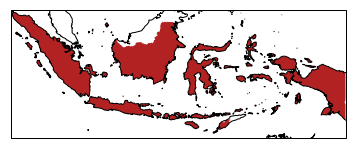

In [15]:
fig = mp.figure()
#map_crs = cartopy.crs.epsg('WGS 84')
#map_crs = cartopy.crs.Geodetic()
map_crs = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_crs)

ax.add_geometries(indonesia.geometry, crs=map_crs, facecolor='firebrick')
ax.set_extent([indonesia.geometry.bounds.minx, indonesia.geometry.bounds.maxx,\
              indonesia.geometry.bounds.miny, indonesia.geometry.bounds.maxy])
ax.coastlines(resolution='10m')

In [24]:
latlon_ds['countries'] = rasterize(countries_shapes, latlon_ds.coords)
specific_country_mask = latlon_ds.countries.where(latlon_ds.countries==country_rownumbers['Indonesia']).values

In [25]:
specific_country_mask.shape

(360, 720)

In [28]:
specific_country_mask[~numpy.isnan(specific_country_mask)]=1.0

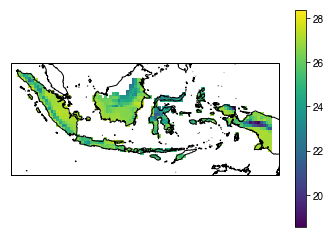

In [29]:
fig = mp.figure()
#map_crs = cartopy.crs.epsg('WGS 84')
#map_crs = cartopy.crs.Geodetic()
map_crs = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_crs)

#ax.add_geometries(indonesia.geometry, crs=map_crs, facecolor='firebrick')
ax.set_extent([indonesia.geometry.bounds.minx-1, indonesia.geometry.bounds.maxx+1,\
              indonesia.geometry.bounds.miny-1, indonesia.geometry.bounds.maxy+1])
ax.coastlines(resolution='10m')

plot = ax.pcolormesh(tmp_lon,tmp_lat,tmp_time_mean*specific_country_mask)

mp.colorbar(plot)